In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings

import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras import regularizers

from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout,MaxPooling2D,Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam , RMSprop
from keras.callbacks import LearningRateScheduler

import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error

from tensorflow.keras.layers import BatchNormalization
import cv2
from tensorflow.keras.optimizers import Adam , Adadelta
import os
import random

In [2]:
import PIL.Image as Image
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def ShowGrayscaleImage(file_path, title='', ax=None):
    
    im = LoadImage(file_path)
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    plt.imshow(im , cmap=plt.cm.gray, vmin=0, vmax=1) #im is of float, 0-1

    plt.title(title)

In [5]:
def find_label(query_key):
    assert len(labels_per_image_csv.index[labels_per_image_csv['query_key']==query_key].tolist())==1

    row_id = labels_per_image_csv.index[labels_per_image_csv['query_key']==query_key].tolist()[0]
    view_label = labels_per_image_csv.iloc[row_id].view_label
    diagnosis_label = labels_per_image_csv.iloc[row_id].diagnosis_label
    
    return view_label, diagnosis_label

In [6]:
labels_per_image_csv = pd.read_csv('../input/labels-per-image/labels_per_image.csv')

In [7]:
raw_data_dir ='../input/labeled/'

In [8]:
labeledset_path = os.path.join(raw_data_dir, 'labeled')
ImageList_labeledset = os.listdir(labeledset_path)
print('number of images in the labeled set: {}'.format(len(ImageList_labeledset))) #as sainty check: should be 27788

number of images in the labeled set: 27788


In [9]:
labeledset_path = os.path.join(raw_data_dir, 'labeled')
ImageList_labeledset = os.listdir(labeledset_path)
print('number of images in the labeled set: {}'.format(len(ImageList_labeledset))) #as sainty check: should be 27788

number of images in the labeled set: 27788


In [10]:
import cv2
images=[]
labels=[]
for i in range(len(ImageList_labeledset)):
    view_label, diagnosis_label = find_label(ImageList_labeledset[i])
    if(diagnosis_label!=''):
        img=cv2.imread(labeledset_path+'/'+ImageList_labeledset[i])
        images.append(img)
        labels.append(diagnosis_label)

In [11]:
import numpy as np
X=np.array(images)
y=labels

In [12]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
y=le.fit_transform(y)

In [13]:
import tensorflow as tf
y = tf.keras.utils.to_categorical(y)

In [14]:
X.shape

(27788, 64, 64, 3)

In [15]:
#X=X.reshape(27788,64,64,1)

In [16]:
X=X/255

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

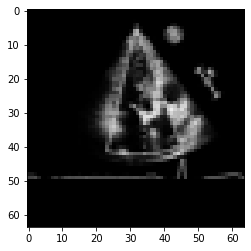

In [18]:
plt.imshow(X[200])

In [19]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [20]:
import tensorflow
X_train =tensorflow.convert_to_tensor(X_train, dtype=tensorflow.float32)
y_train = tensorflow.convert_to_tensor(y_train, dtype=tensorflow.float32)

X_test = tensorflow.convert_to_tensor(X_test, dtype=tensorflow.float32)
y_test = tensorflow.convert_to_tensor(y_test, dtype=tensorflow.float32)

X_valid = tensorflow.convert_to_tensor(X_valid, dtype=tensorflow.float32)
y_valid = tensorflow.convert_to_tensor(y_valid, dtype=tensorflow.float32)

2022-07-11 15:27:53.227974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:27:53.345307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:27:53.346017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:27:53.350200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
input_shape = (64,64,3)
num_classes = 3
batch_size = 10
epochs = 75

In [32]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(num_classes))
    gmodel.add(Activation('softmax'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='categorical_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.h5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [ ]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
model = getModel()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)      

In [34]:
# Fit the model
history = model.fit(X_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_valid,y_valid),
                              verbose = 1)

Epoch 1/75


2022-07-11 15:39:54.577861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1946/1946 [==============================] - 18s 6ms/step - loss: 1.0501 - accuracy: 0.4410 - val_loss: 1.0194 - val_accuracy: 0.4593
Epoch 2/75
1946/1946 [==============================] - 10s 5ms/step - loss: 0.9973 - accuracy: 0.4798 - val_loss: 0.9706 - val_accuracy: 0.5054
Epoch 3/75
1946/1946 [==============================] - 10s 5ms/step - loss: 0.9538 - accuracy: 0.5172 - val_loss: 0.9188 - val_accuracy: 0.5332
Epoch 4/75
1946/1946 [==============================] - 10s 5ms/step - loss: 0.9197 - accuracy: 0.5410 - val_loss: 0.8810 - val_accuracy: 0.5567
Epoch 5/75
1946/1946 [==============================] - 10s 5ms/step - loss: 0.9000 - accuracy: 0.5564 - val_loss: 0.8687 - val_accuracy: 0.5670
Epoch 6/75
1946/1946 [==============================] - 10s 5ms/step - loss: 0.8777 - accuracy: 0.5680 - val_loss: 0.8472 - val_accuracy: 0.5838
Epoch 7/75
1946/1946 [==============================] - 10s 5ms/step - loss: 0.8631 - accuracy: 0.5798 - val_loss: 0.8465 - val_accuracy: 0.6

In [35]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [36]:
y_pred=np.argmax(y_pred, axis=1)

In [37]:
yyy_test = np.argmax(y_test , axis = 1)

In [38]:
print("Model Accuracy is : " , accuracy_score(yyy_test, y_pred) )

Model Accuracy is :  0.7324856046065259


In [39]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.6062806248664856
Test accuracy: 0.7324855923652649


Text(0, 0.5, 'Loss')

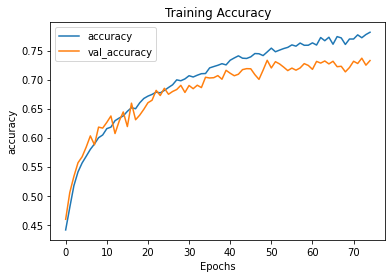

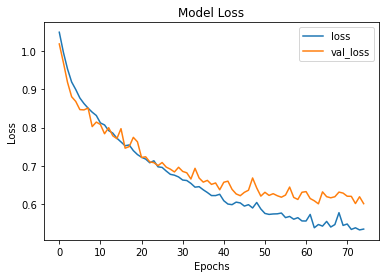

In [40]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [41]:
model.save_weights("echoclassification.h5")

In [42]:
model.save('Classification_echo.h5')